In [2]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.api.layers import *


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [3]:
monetFilenames = [os.path.join("C:\\Users\\fredd\\IdeaProjects\\OverallSisrNNCNNProject\\BackEnd\\Code\\CyclicalGAN\\gan-getting-started\\monet_jpg", f) for f in os.listdir("C:\\Users\\fredd\\IdeaProjects\\OverallSisrNNCNNProject\\BackEnd\\Code\\CyclicalGAN\\gan-getting-started\\monet_jpg")]
photoFilenames = [os.path.join("C:\\Users\\fredd\\IdeaProjects\\OverallSisrNNCNNProject\\BackEnd\\Code\\CyclicalGAN\\gan-getting-started\\photo_jpg", f) for f in os.listdir("C:\\Users\\fredd\\IdeaProjects\\OverallSisrNNCNNProject\\BackEnd\\Code\\CyclicalGAN\\gan-getting-started\\photo_jpg")]

In [4]:
def read_image(file_path):
    with open(file_path, 'rb') as f:
        image_data = f.read()
    return image_data

def decodeAndResizeImage(image, size=(256, 256)):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def loadDataset(filenames):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(lambda x: tf.numpy_function(read_image, [x], tf.string), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x: decodeAndResizeImage(x), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(1, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
monetDataSet = loadDataset(monetFilenames)
photoDataSet = loadDataset(photoFilenames)

In [6]:
exampleMonet = next(iter(monetDataSet))
examplePhoto = next(iter(photoDataSet))

In [7]:
print(exampleMonet[0].shape)

(256, 256, 3)


Monet image shape: (1, 256, 256, 3)
Photo image shape: (1, 256, 256, 3)


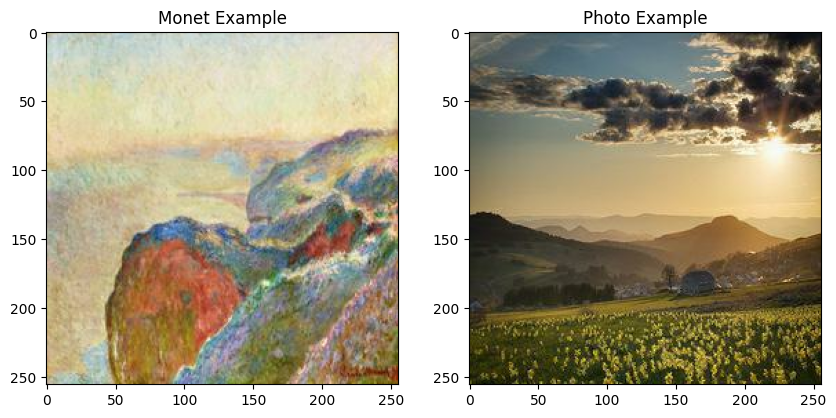

In [8]:
print("Monet image shape:", exampleMonet.shape)
print("Photo image shape:", examplePhoto.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Monet Example")
plt.imshow((exampleMonet[0] + 1) / 2)  # Convert back to [0, 1] range for display

plt.subplot(1, 2, 2)
plt.title("Photo Example")
plt.imshow((examplePhoto[0] + 1) / 2)  # Convert back to [0, 1] range for display

plt.show()

In [9]:
def doubleConvBlock(x, filters, size):
    x = Conv2D(filters, size, strides=1, padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(filters, size, strides=1, padding='same')(x)
    x = ReLU()(x)
    skip = x
    return x, skip

In [10]:
def downSample(x, filters, size):
    x, skip = doubleConvBlock(x, filters, size)
    x = MaxPooling2D()(x)
    return x, skip

In [11]:
def upSample(x, downSampleLayer, filters, size):
    x = Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False)(x)
    x = Concatenate()([x, downSampleLayer])
    x, _ = doubleConvBlock(x, filters, size)
    return x

In [12]:
def Generator(inputShape=[256, 256, 3]):
    inputs = Input(inputShape)
    x, d1 = downSample(inputs, 64, 4) #(bs, 128, 128, 64)
    x, d2 = downSample(x, 128, 4)#(bs, 64, 64, 128)
    x, d3 = downSample(x, 256, 4)#(bs, 32, 32, 256)
    x, d4 = downSample(x, 512, 4)#(bs, 16, 16, 512)
    x, d5 = downSample(x, 512, 4)#(bs, 8, 8, 512)
    x, d6 = downSample(x, 512, 4)#(bs, 4, 4, 512)
    x, d7 = downSample(x, 512, 4)#(bs, 2, 2, 512)
    x, d8 = downSample(x, 512, 4)#(bs, 1, 1, 512)
    
    x, skip = doubleConvBlock(x, 512, 4)#(bs, 1, 1, 512)
    
    x = upSample(x, d8, 512, 4)#(bs, 2, 2, 1024)
    x = upSample(x, d7, 512, 4)#(bs, 4, 4, 1024)
    x = upSample(x, d6, 512, 4)#(bs, 8, 8, 1024)
    x = upSample(x, d5, 512, 4)#(bs, 16, 16, 1024)
    x = upSample(x, d4, 256, 4)#(bs, 32, 32, 512)
    x = upSample(x, d3, 128, 4)#(bs, 64, 64, 256)
    x = upSample(x, d2, 64, 4)#(bs, 128, 128, 128)
    x = upSample(x, d1, 32, 4)#(bs, 256, 256, 64)
    
    last = Conv2DTranspose(3, 4, padding='same', activation='tanh')(x)
    outputs = last

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [13]:
def Discriminator():
    input = Input((256, 256, 3))
    
    x, _ = downSample(input, 64, 4)
    x, _ = downSample(x, 128, 4)
    x, _ = downSample(x, 256, 4)
    
    x = ZeroPadding2D()(x)
    
    x = Conv2D(512, 4, strides=1)(x)

    x = LeakyReLU()(x)

    x = ZeroPadding2D()(x)
    
    x = Conv2D(1, 4, strides=1)(x)
    
    model = keras.Model(inputs=input, outputs=x)
    
    return model
    

In [14]:
with strategy.scope():
    monetGenerator = Generator()
    photoGenerator = Generator() 
    
    monetDiscriminator = Discriminator()
    photoDiscriminator = Discriminator()

In [15]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambdaCycle=10):
        super(CycleGAN, self).__init__()
        self.identityLoss = None
        self.cycleLoss = None
        self.discLoss = None
        self.genLoss = None
        self.photoDiscrimOptiniser = None
        self.monetDiscrimOptimiser = None
        self.photoGenOptimiser = None
        self.monetGenOptimiser = None
        self.monetGen = monet_generator
        self.photoGen = photo_generator
        self.monetDiscrim = monet_discriminator
        self.photoDiscrim = photo_discriminator
        self.lambdaCycle = lambdaCycle
        
    def compile(self, monetGenOptimiser, photoGenOptimiser, monetDiscrimOptimiser, photoDiscrimOptiniser, genLoss, discLoss, cycleLoss, identityLoss):
        super(CycleGAN, self).compile()
        self.monetGenOptimiser = monetGenOptimiser
        self.photoGenOptimiser = photoGenOptimiser
        self.monetDiscrimOptimiser = monetDiscrimOptimiser
        self.photoDiscrimOptiniser = photoDiscrimOptiniser
        self.genLoss = genLoss
        self.discLoss = discLoss
        self.cycleLoss = cycleLoss
        self.identityLoss = identityLoss
        
    def train_step(self, batchData):
        realMonet, realPhoto = batchData

        with tf.GradientTape(persistent=True) as tape:
            fakeMonet = self.monetGen(realPhoto, training=True)
            cycledPhoto = self.photoGen(fakeMonet, training=True)

            fakePhoto = self.photoGen(realMonet, training=True)
            cycledMonet = self.monetGen(fakePhoto, training=True)

            sameMonet = self.monetGen(realMonet, training=True)
            samePhoto = self.photoGen(realPhoto, training=True)

            discRealMonet = self.monetDiscrim(realMonet, training=True)
            discRealPhoto = self.photoDiscrim(realPhoto, training=True)

            discFakeMonet = self.monetDiscrim(fakeMonet, training=True)
            discFakePhoto = self.photoDiscrim(fakePhoto, training=True)
    
    
            monetGenLoss = self.genLoss(discFakeMonet)
            photoGenLoss = self.genLoss(discFakePhoto)

            totalCycleLoss = self.cycleLoss(realMonet, cycledMonet, self.lambdaCycle) + self.cycleLoss(realPhoto, cycledPhoto, self.lambdaCycle)
            
            totalMonetLoss = monetGenLoss + totalCycleLoss + self.identityLoss(realMonet, sameMonet, self.lambdaCycle)
            totalPhotoLoss = photoGenLoss + totalCycleLoss + self.identityLoss(realPhoto, samePhoto, self.lambdaCycle)
        
            monetDiscLoss = self.discLoss(discRealMonet, discFakeMonet)
            photoDiscLoss = self.discLoss(discRealPhoto, discFakePhoto)

            monetGeneratorGradients = tape.gradient(totalMonetLoss, self.monetGen.trainable_variables)
            photoGeneratorGradients = tape.gradient(totalPhotoLoss, self.photoGen.trainable_variables)
            monetDiscrimGradients = tape.gradient(totalMonetLoss, self.monetDiscrim.trainable_variables)
            photoDiscrimGradients = tape.gradient(totalPhotoLoss, self.photoDiscrim.trainable_variables)
            
            self.monetGenOptimiser.apply_gradients(zip(monetGeneratorGradients, self.monetGen.trainable_variables)) 
            self.photoGenOptimiser.apply_gradients(zip(photoGeneratorGradients, self.photoGen.trainable_variables))
            self.monetDiscrimOptimiser.apply_gradients(zip(monetDiscrimGradients, self.photoGen.trainable_variables))
            self.photoDiscrimOptiniser.apply_gradients(zip(photoDiscrimGradients, self.photoGen.trainable_variables))


            return {
                "monet_gen_loss": totalMonetLoss,
                "photo_gen_loss": totalPhotoLoss,
                "monet_disc_loss": monetDiscLoss,
                "photo_disc_loss": photoDiscLoss
            }

In [16]:
with strategy.scope():
    def discriminatorLoss(real, generated):
        realLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        genLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        
        totalLossAvg = (realLoss + genLoss)/2
        
        return totalLossAvg
    
    def calcCycleLoss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    
        return LAMBDA * loss1
    
    def generatorLoss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def identityLoss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [17]:
with strategy.scope():
    monetGeneratorOptimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
    photoGeneratorOptimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
    
    monetDiscriminatorOptimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
    photoDiscriminatorOptimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [18]:
with strategy.scope():
    cycleGan = CycleGAN(monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator)
    
    cycleGan.compile(monetGeneratorOptimizer, photoGeneratorOptimizer, monetDiscriminatorOptimizer, photoDiscriminatorOptimizer, genLoss=generatorLoss, discLoss=discriminatorLoss, cycleLoss=calcCycleLoss, identityLoss=identityLoss)


In [ ]:
cycleGan.fit(tf.data.Dataset.zip((monetDataSet, photoDataSet)), epochs=25)

Epoch 1/25
 49/300 ━━━━━━━━━━━━━━━━━━━━ 2:13:29 32s/step - monet_disc_loss: 0.6870 - monet_gen_loss: 7.0130 - photo_disc_loss: 0.6935 - photo_gen_loss: 7.2949